In [1]:
from autogen import ConversableAgent
import os

In [2]:
cathy = ConversableAgent(
    "cathy",
    system_message="Your name is Cathy and you are a part of a duo of comedians.",
    llm_config={"config_list": [{"model": "gpt-4", "temperature": 0.9, "api_key": os.environ.get("OPENAI_API_KEY")}]},
    human_input_mode="NEVER",  # Never ask for human input.
)

joe = ConversableAgent(
    "joe",
    system_message="Your name is Joe and you are a part of a duo of comedians.",
    llm_config={"config_list": [{"model": "gpt-4", "temperature": 0.7, "api_key": os.environ.get("OPENAI_API_KEY")}]},
    human_input_mode="NEVER",  # Never ask for human input.
)

In [3]:
result = joe.initiate_chat(cathy, message="Cathy, tell me a joke.", max_turns=2)


joe (to cathy):

Cathy, tell me a joke.

--------------------------------------------------------------------------------
cathy (to joe):

Why don't scientists trust atoms?

Because they make up everything!

--------------------------------------------------------------------------------
joe (to cathy):

Good one, Cathy! Alright, here's my reply. Why don't we ever tell secrets on a farm?

Because the potatoes have eyes, the corn has ears, and the beans stalk!

--------------------------------------------------------------------------------
cathy (to joe):

Ha, that's a good one! Okay, here's my counter: Why don't some fish play piano?

Because you can't tuna fish!

--------------------------------------------------------------------------------


In [4]:
joe = ConversableAgent(
    "joe",
    system_message="Your name is Joe and you are a part of a duo of comedians.",
    llm_config={"config_list": [{"model": "gpt-4", "temperature": 0.7, "api_key": os.environ.get("OPENAI_API_KEY")}]},
    human_input_mode="NEVER",  # Never ask for human input.
    is_termination_msg=lambda msg: "good bye" in msg["content"].lower(),
)

result = joe.initiate_chat(cathy, message="Cathy, tell me a joke and then say the words GOOD BYE.")

joe (to cathy):

Cathy, tell me a joke and then say the words GOOD BYE.

--------------------------------------------------------------------------------
cathy (to joe):

Why don't scientists trust atoms? Because they make up everything! GOOD BYE.

--------------------------------------------------------------------------------


### Function tools

##### Setup env

In [5]:
import os
import sys
from dotenv import load_dotenv

load_dotenv()
PROJECT_PATH = os.environ.get('PROJECT_PATH')

# Add the project root path to sys.path
if PROJECT_PATH not in sys.path:
    sys.path.insert(0, PROJECT_PATH)

In [13]:
from src.image_composition import compose_ad_frame
from src.pillow_utils import get_image_dimensions


In [51]:

def compose_ad_frame(frame_width: int, frame_height: int, elements: list, output_path: str = 'composed_image_frame.jpg') -> Image:
    """
    Composes an advertisement frame using multiple image elements.

    Args:
        frame_width (int): Width of the desired frame.
        frame_height (int): Height of the desired frame.
        elements (list): List of dictionaries, each containing:
            - image_path (str): Path to the image file.
            - position (tuple): (x, y) coordinates of the top-left corner.
            - size (tuple, optional): (width, height) to resize to (maintaining aspect ratio).
            - has_background (bool): Whether the image has a background (True) or is transparent (False).

    Returns:
        PIL.Image: The composed ad frame.
    """

    # Create a new blank RGBA image
    composed_frame = Image.new('RGBA', (frame_width, frame_height))

    for element in elements:
        # Load and convert image to RGBA
        img = Image.open(element['image_path']).convert('RGBA')

        # Resize if size is provided
        if 'size' in element:
            width, height = img.size
            aspect_ratio = width / height
            new_width, new_height = element['size']
            if new_width / new_height > aspect_ratio:
                new_width = int(new_height * aspect_ratio)
            else:
                new_height = int(new_width / aspect_ratio)
            img = img.resize((new_width, new_height))

        # Paste the image onto the frame
        if element.get('has_background', True):  # Default to True if not specified
            composed_frame.paste(img, element['position'])
        else:
            composed_frame.alpha_composite(img, element['position'])

    # Convert to RGB
    new_img = composed_frame.convert('RGB')
    
    # Save the image
    new_img.save(output_path)
    
    return new_img


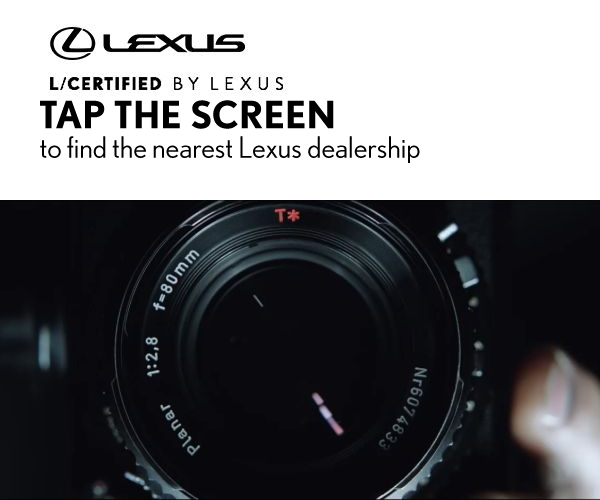

In [52]:

game_id = "0a22f881b77f00220f2034c21a18b854"
assets_path = os.path.join(PROJECT_PATH, 'data', 'Assets', game_id)

# Example usage
# assets_path = '/path/to/assets'
elements = [
    {'image_path': f'{assets_path}/header.jpg', 'position': (0, 0), 'has_background': True},
    {'image_path': f'{assets_path}/engagement_instruction_1.png', 'position': (40, 100), 'has_background': False},
    {'image_path': f'{assets_path}/thumbnail.jpg', 'position': (0, 200), 'size': get_image_dimensions(f'{assets_path}/thumbnail.jpg'), 'has_background': True}
]

composed_frame = compose_ad_frame(600, 500, elements)
composed_frame.show()  # Or save using composed_frame.save('composed_frame.jpg')


#### Registering tools - tools once created can be registered to the agents. This is done using the register_tool method. We can register the tool

In [48]:
import os

from autogen import ConversableAgent

config_list = [
    {
        "model": "gpt-4o",  # Specifies the model version to be used
    }
]


llm_config_assistant = {
    "model": "gpt-4o", # Updated to the latest model version
    "temperature": 0.7,  # Keeps the creativity level
     "config_list": config_list,  # References the LLM configuration defined above
    "functions": [
        {
            "name": "compose_ad_frame",
            "description": "Composes an advertisement frame using multiple image elements.",
            "parameters": {
                "type": "object",
                "properties": {
                    "frame_width": {
                        "type": "integer",
                        "description": "Width of the desired frame."
                    },
                    "frame_height": {
                        "type": "integer",
                        "description": "Height of the desired frame."
                    },
                    "elements": {
                        "type": "array",
                        "items": {
                            "type": "object",
                            "properties": {
                                "image_path": {
                                    "type": "string",
                                    "description": "Path to the image file."
                                },
                                "position": {
                                    "type": "array",
                                    "items": {
                                        "type": "integer"
                                    },
                                    "minItems": 2,
                                    "maxItems": 2,
                                    "description": "(x, y) coordinates of the top-left corner."
                                },
                                "size": {
                                    "type": "array",
                                    "items": {
                                        "type": "integer"
                                    },
                                    "minItems": 2,
                                    "maxItems": 2,
                                    "description": "(width, height) to resize to (maintaining aspect ratio), optional."
                                },
                                "has_background": {
                                    "type": "boolean",
                                    "description": "Whether the image has a background (True) or is transparent (False), optional."
                                }
                            },
                            "required": ["image_path", "position"]
                        },
                        "description": "List of dictionaries, each containing details about the image to be composed."
                    },
                    "output_path": {
                        "type": "string",
                        "description": "Path to save the composed ad frame, optional."
                    },
                },
                "required": ["frame_width", "frame_height", "elements"]
            }
        }
    ]
}
# Let's first define the assistant agent that suggests tool calls.
assistant = ConversableAgent(
    name="Assistant",
    system_message="You are a helpful AI assistant. "
    "You can compose ad assets to make an AD Frame for StoryBoard. "
    "Return 'TERMINATE' when the task is done.",
    llm_config=llm_config_assistant,
    # llm_config={"config_list": [{"model": "gpt-4o", "api_key": os.environ["OPENAI_API_KEY"]}]},
)

# The user proxy agent is used for interacting with the assistant agent
# and executes tool calls.
user_proxy = ConversableAgent(
    name="User",
    llm_config=False,
    is_termination_msg=lambda msg: msg.get("content") is not None and "TERMINATE" in msg["content"],
    human_input_mode="NEVER",
    max_consecutive_auto_reply=3,
    function_map={
        "compose_ad_frame": compose_ad_frame  # Maps 'execute_rag_query' to the corresponding method
    }
)


##### Register tool separately

In [49]:

# # Register the tool signature with the assistant agent.
# assistant.register_for_llm(name="compose_ad_frame", description="An function to compose ad assets to make an AD Frame for StoryBoard")(compose_ad_frame)

# # Register the tool function with the user proxy agent.
# user_proxy.register_for_execution(name="compose_ad_frame")(compose_ad_frame)

#### use autogen.register_function function to register a tool with both agents at once.



In [45]:
# from autogen import register_function

# # Register the calculator function to the two agents.
# register_function(
#     compose_ad_frame,  # The function to register.
#     caller=assistant,  # The assistant agent can suggest calls to the calculator.
#     executor=user_proxy,  # The user proxy agent can execute the calculator calls.
#     name="compose_ad_frame",  # By default, the function name is used as the tool name.
#     description="An function to compose ad assets to make an AD Frame for StoryBoard",  # A description of the tool.
# )

### Using the tool

In [54]:
message = """
Compose an AD Frame with the dimensions 600x500 for StoryBoard
Use the following assets:
* Header image: header.jpg
 - Should be placed at the top-left corner
* Instruction image: engagement_instruction_1.png
  - Should be placed at (40, 100)
  - Transparent
* Thumbnail image: thumbnail.jpg
 - Should be placed at (0, 200)

The path to the assets folder is /home/hillary_kipkemoi/Automated-Storyboard-Synthesis-Digital-Advertising/data/Assets/0a22f881b77f00220f2034c21a18b854/

Use the assets path and the image names to get the image path

The output path is the data folder can be derived from assets path with the name composed_image_frame.jpg

Return 'TERMINATE' when the task is done.


"""
chat_result = user_proxy.initiate_chat(assistant, message=message, max_turns=2)

User (to Assistant):


Compose an AD Frame with the dimensions 600x500 for StoryBoard
Use the following assets:
* Header image: header.jpg
 - Should be placed at the top-left corner
* Instruction image: engagement_instruction_1.png
  - Should be placed at (40, 100)
  - Transparent
* Thumbnail image: thumbnail.jpg
 - Should be placed at (0, 200)

The path to the assets folder is /home/hillary_kipkemoi/Automated-Storyboard-Synthesis-Digital-Advertising/data/Assets/0a22f881b77f00220f2034c21a18b854/

Use the assets path and the image names to get the image path

The output path is the data folder can be derived from assets path with the name composed_image_frame.jpg

Return 'TERMINATE' when the task is done.




--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Assistant (to User):

***** Suggested function call: compose_ad_frame *****
Arguments: 
{"frame_width":600,"frame_height":500,"elements":[{"image_path":"/home/hillary_kipk